In [1]:
import sys
sys.path.append("/home/wanxinli/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *
import os
import pandas as pd
from statistics import median, stdev

In [2]:

def ratios_for_metrics(group_name, group_2, group_1, eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    score_dir = mimic_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


In [3]:
def print_median_std(ratios, trans_metrics, eval_metric):
    """ 
    Get median and standard deviation for the ratios of trans_metrics ('OT', 'TCA', 'MMD')
    """
    for i, trans_metric in enumerate(trans_metrics):
        print(f'{eval_metric} for {trans_metric}, Median: {median(ratios[i]):.1%}, Stdev: {stdev(ratios[i]):.1%}')

In [8]:
score_dir = "/home/wanxinli/OTTEHR/outputs/mimic/"

eval_metric = 'MAE'
# eval_metric = 'RMSE'

group_name = 'insurance'
groups = ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid']

# group_name = 'marital_status'
# groups = ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']

trans_metrics = ['OT', 'TCA', 'CA', 'GFK']



medians for each method is: [ 0.34539171 -0.00239518 -0.00602988 -0.53425542]


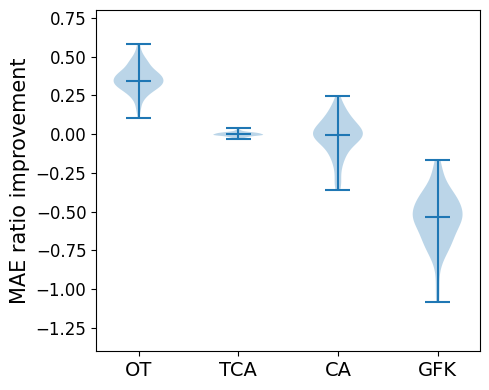

In [9]:
# Overall, for all groups
improve_ratio_combined = []

for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue        
        improve_ratios = ratios_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics)
        improve_ratio_combined.extend(improve_ratios)

trans_metric_dict = {}
for i in range(len(trans_metrics)):
    trans_metric_dict[trans_metrics[i]] = improve_ratio_combined[i]
# print(np.median(trans_metric_dict['GWOT']))
data = pd.DataFrame(trans_metric_dict)
print("medians for each method is:", np.median(data, axis=0))


# Plot the dataframe
plt.figure(figsize=[5, 4])
plt.violinplot(data, showmedians=True)
plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metrics)
plt.ylabel(f"{eval_metric} ratio improvement", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_xticklabels( labels=trans_metrics, fontsize=14)
plt.ylim(-1.4, 0.8)
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{eval_metric}.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [6]:
def print_latex(source, target, ratios):
    """ 
    Print latex for ratios
    """
    print_str = f"{source} & {target}"
    for ratio in ratios:
        print_str += f' & {median(ratio)*100:.1f}({stdev(ratio)*100:.1f})'
    print(print_str)
    

In [7]:
for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if i <= j:
            continue
        # print(f"group 1: {group_1}, group_2: {group_2}")
        # mae_improve_ratios = ratios_for_metrics(group_name, group_1, group_2, 'mae', trans_metrics)
        # print_median_std(mae_improve_ratios, trans_metrics, 'MAE')
        rmse_improve_ratios = ratios_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics)
        # print(rmse_improve_ratios)
        # print_median_std(rmse_improve_ratios, trans_metrics, eval_metric)
        print_latex(group_1, group_2, rmse_improve_ratios)

Private & Self_Pay & 8.9(7.1) & -0.3(0.7) & -1.9(9.2) & -9.7(8.2)
Government & Self_Pay & 10.1(8.8) & 0.0(0.7) & -0.3(8.6) & -11.3(12.1)
Government & Private & 24.8(12.8) & 0.9(2.1) & -0.8(12.6) & -35.9(24.2)
Medicare & Self_Pay & 23.6(12.3) & 0.2(0.6) & -3.0(8.8) & -29.4(20.7)
Medicare & Private & 45.4(11.6) & -0.1(1.5) & -2.0(11.0) & -75.0(31.0)
Medicare & Government & 43.1(12.0) & -0.2(1.3) & 1.9(10.7) & -69.8(29.6)
Medicaid & Self_Pay & 9.0(7.4) & -0.2(0.7) & -1.6(7.0) & -9.4(8.4)
Medicaid & Private & 21.4(12.6) & 0.4(1.8) & 1.2(10.0) & -27.6(21.1)
Medicaid & Government & 21.1(12.1) & 0.3(1.1) & -2.4(11.0) & -25.5(18.2)
Medicaid & Medicare & 7.1(9.3) & 0.1(0.4) & -2.2(9.6) & -8.0(12.5)
